# Baseline Artificial Neural Network

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

## Load Data

In [2]:
from utils2 import load_vars_xarray, split_input_output
input_vars = 'state_q0001 state_t pbuf_SOLIN pbuf_LHFLX pbuf_SHFLX state_ps'.split()
output_vars = ['state_q0001', 'state_t', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECC']
ds = load_vars_xarray(input_vars, output_vars, True, True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Daily average


In [5]:
selected_levels = np.append(np.linspace(4, 24, 6), np.linspace(26, 59, 14)).astype(np.int32)
ds = ds.isel(lev=selected_levels)
ds = ds.isel(time = slice(0, 4*365), ncol=slice(0, 16))

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds.load()

[######################################  ] | 96% Completed | 592.15 s

In [8]:
ds

<xarray.Dataset>
Dimensions:            (time: 1460, lev: 20, ncol: 16)
Coordinates:
  * time               (time) object 0001-02-01 12:00:00 ... 0005-01-31 12:00:00
  * ncol               (ncol) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    lat                (ncol) float64 -32.59 -35.99 -22.69 ... -25.37 -22.69
    lon                (ncol) float64 -39.73 -28.47 -39.56 ... 39.73 28.31 39.56
Dimensions without coordinates: lev
Data variables:
    state_q0001        (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01655
    state_t            (time, lev, ncol) float64 257.8 258.9 ... 301.3 299.2
    pbuf_SOLIN         (time, ncol) float64 477.9 475.6 476.4 ... 479.3 477.5
    pbuf_LHFLX         (time, ncol) float64 77.19 113.1 184.8 ... 16.02 157.0
    pbuf_SHFLX         (time, ncol) float64 3.864 9.653 51.89 ... 126.7 21.06
    state_ps           (time, ncol) float64 1.011e+05 1.013e+05 ... 9.759e+04
    out_state_q0001    (time, lev, ncol) float64 1.424e-06 1.455e-06 ... 0.01653
    out_state_t        (time, lev, ncol) float64 257.8 258.9 ... 301.1 299.2
    out_cam_out_NETSW  (time, ncol) float64 332.9 313.0 243.3 ... 259.3 268.9
    out_cam_out_FLWDS  (time, ncol) float64 354.8 339.1 399.6 ... 407.3 419.9
    out_cam_out_PRECC  (time, ncol) float64 2.325e-11 1.05e-09 ... 1.685e-08
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [24]:
def normalize(xarr):
    var_means = xarr.mean(dim=['time', 'ncol']) # spatiotemporal mean
    var_stds = xarr.std(dim=['time', 'ncol']) # spatiotemporal meana
    arr = (xarr - var_means) / var_stds
    
    means = []
    stds = []
    for var in arr.data_vars:
        means.append(var_means[var].values.reshape(-1, 1))
        stds.append(var_stds[var].values.reshape(-1, 1))
    return(arr, np.vstack(means)[:, 0], np.vstack(stds)[:,0])

ds_mean, mu, sigma = normalize(ds)

In [134]:
train = ds_mean.isel(time = slice(0, 3 * 365 + 1))
test = ds_mean.isel(time = slice(3*365 + 1, 4*365))

#### Tensorflow

In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

ModuleNotFoundError: No module named 'tensorflow'

In [86]:
def load_tf_dataset(ds):
    def gen():
        i = 0
        X, Y = split_input_output(ds)
        while(i < ds.time.size * ds.ncol.size):
            t, col = i // ds.ncol.size, i % ds.ncol.size
            x = X.isel(time=t, ncol=[col])
            y = Y.isel(time=t, ncol=[col])

            x = x.to_stacked_array("v", sample_dims=["ncol"]).values
            y = y.to_stacked_array("v", sample_dims=["ncol"]).values

            yield x[0], y[0]
            i += 1
    return tf.data.Dataset.from_generator(gen, output_types=(tf.float64, tf.float64), 
                                    output_shapes=((44,), (43,)))

In [135]:
X_train, Y_train = split_input_output(train)
X_test, Y_test = split_input_output(test)

In [3]:
X_train_np = X_train.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_train_np = Y_train.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

X_test_np = X_test.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 44)
Y_test_np = Y_test.to_stacked_array("v", sample_dims=["ncol", 'time']).values.reshape(-1, 43)

NameError: name 'X_train' is not defined

In [1]:
print(X_train_np.shape)
print(Y_train_np.shape)

NameError: name 'X_train_np' is not defined

In [2]:
print(X_test_np.shape)
print(Y_test_np.shape)

NameError: name 'X_test_np' is not defined

In [87]:
train_ds = load_tf_dataset(train).

In [94]:
batches = iter(train_ds.shuffle(96).repeat().batch(32))


In [101]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#### Pytorch since TF not working

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
class MyDataset(Dataset):
    def __init__(self, ds, device = "cuda" if torch.cuda.is_available() else "cpu"):
        self.ds = ds
        self.X_ds, self.Y_ds = split_input_output(ds)
        self.device = device
        
        self.X_norm, self.X_mean, self.X_std = normalize(self.X_ds)
        self.Y_norm, self.Y_mean, self.Y_std = normalize(self.Y_ds)
        
    def __len__(self):
        return( self.ds.time.size * self.ds.ncol.size )
    
    def __getitem__(self, idx):
        t, col = idx // self.ds.ncol.size, idx % self.ds.ncol.size
        X = self.X_norm.isel(time=t, ncol=[col])
        Y = self.Y_norm.isel(time=t, ncol=[col])
        
        X = X.to_stacked_array("v", sample_dims=["ncol"]).values
        Y = Y.to_stacked_array("v", sample_dims=["ncol"]).values
        
        X = torch.as_tensor(X, device=self.device, dtype=torch.float32)
        Y = torch.as_tensor(Y, device=self.device, dtype=torch.float32)
        return(X.flatten(), Y.flatten())

In [32]:
dataset = MyDataset(train, device)

# Training Pytorch model

### Linear Model

In [142]:
len(X_train_np) / 32

548.0

In [18]:
# set hyperparameters
insize = 44
outsize = 43
n_neuron       = 32
num_epochs     = 30
learning_rate  = 0.005
minibatch_size = 32
model_num      = 1
N_layers       = 1 # number of hidden layers

In [174]:
class LinearModel(nn.Module):
    def __init__(self, insize=44, outsize=43):
        super(LinearModel, self).__init__()
        # set hyperparameters
        n_neuron       = 32
        model_num      = 1
        N_layers       = 1 # number of hidden layers
        
        self.linears = torch.nn.Sequential(torch.nn.Linear(insize, n_neuron))
        for i in range(N_layers):
            self.linears.append(torch.nn.Linear(n_neuron, n_neuron))
        self.linears.append(torch.nn.Linear(n_neuron, outsize))
    
    def forward(self, x):
        return(self.linears(x))


In [206]:
linear_model = LinearModel().to(device)
linear_model

LinearModel(
  (linears): Sequential(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=43, bias=True)
  )
)

In [178]:
((y - y_hat.cpu().detach().numpy()) ** 2).mean()

1.0456288040474413

In [229]:
import sys
def train_model(model, num_epochs=10, learning_rate=0.001, minibatch_size=32):
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    
    losses = []
    
    dataloader = DataLoader(dataset, shuffle=True, batch_size=minibatch_size)
    for epoch in range(num_epochs):
        start = time.time()
        for batch in range(len(dataloader)):
            x = X_train_np[minibatch_size * batch: minibatch_size * (batch + 1), :]
            y = Y_train_np[minibatch_size * batch:minibatch_size * (batch + 1), :]
            x = torch.tensor(x, device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            
            y_hat = model(x)
            loss = loss_fn(y, y_hat)
            loss.backward()
            if(batch % 250 == 0):
                losses.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
        
        sys.stdout.write(f"\rEpoch Number {1 + epoch}, loss: {loss.item()}, epoch time: {(time.time() - start) / 60}        ")  
        sys.stdout.flush()
    return(model, losses)
            
    

In [210]:
linear_model, losses = train_model(linear_model, 30, 0.001, 32)

Epoch Number 30, loss: 0.19312305748462677, epoch time: 0.008035699526468912        

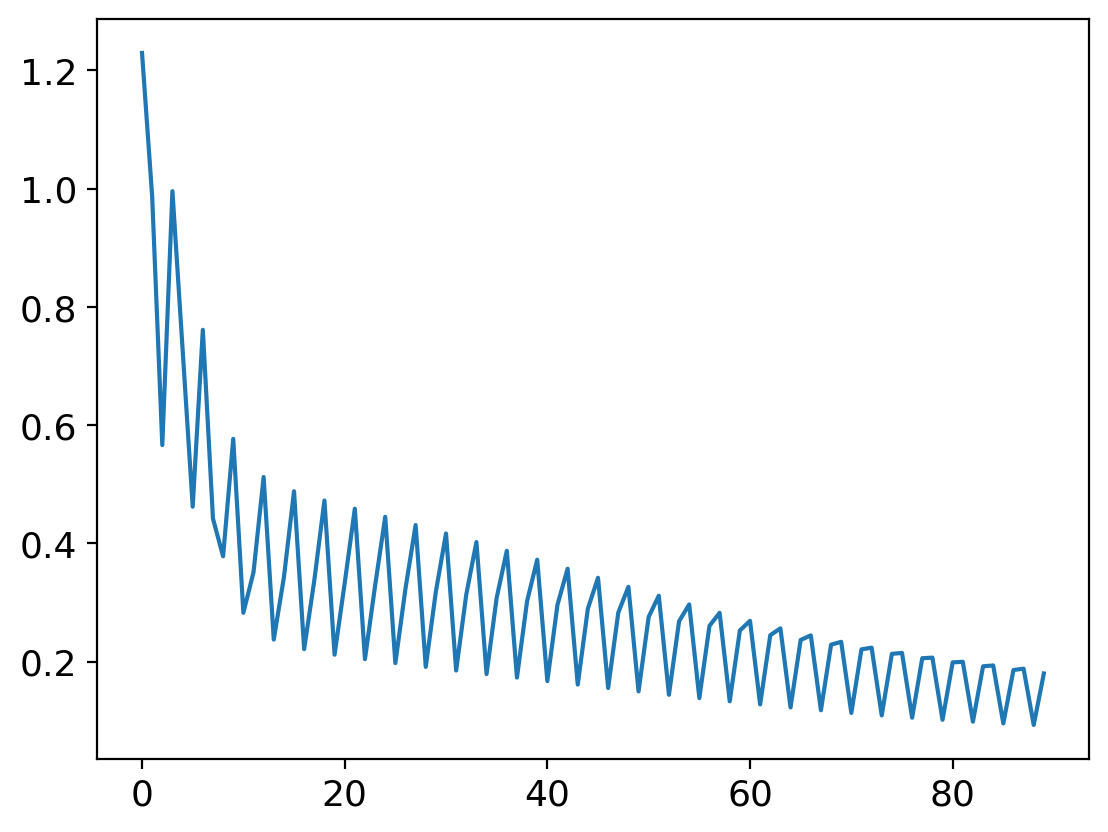

In [211]:
plt.plot(losses)

In [247]:
torch.save(linear_model, 'saved_data/models/linear_model.pt')

In [248]:
torch.save(ann, 'saved_data/models/ANN_baseline.pt')

### ANN

In [230]:
class ANN(nn.Module):
    def __init__(self, insize=44, outsize=43):
        super(ANN, self).__init__()
        # set hyperparameters
        n_neuron       = 32
        model_num      = 1
        N_layers       = 2 # number of hidden layers
        
        self.layers = torch.nn.Sequential(torch.nn.Linear(insize, n_neuron), nn.ReLU())
        for i in range(N_layers):
            self.layers.append(torch.nn.Linear(n_neuron, n_neuron))
            self.layers.append(nn.ReLU())
        self.layers.append(torch.nn.Linear(n_neuron, outsize))
    
    def forward(self, x):
        return(self.layers(x))

In [237]:
ann = ANN().to(device)
ann

ANN(
  (layers): Sequential(
    (0): Linear(in_features=44, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=43, bias=True)
  )
)

In [241]:
ann, losses = train_model(ann, 100, 0.001, 32)

Epoch Number 100, loss: 0.2822047472000122, epoch time: 0.010386768976847332        

In [243]:
kernel_size = 20
kernel = np.ones(kernel_size) / kernel_size

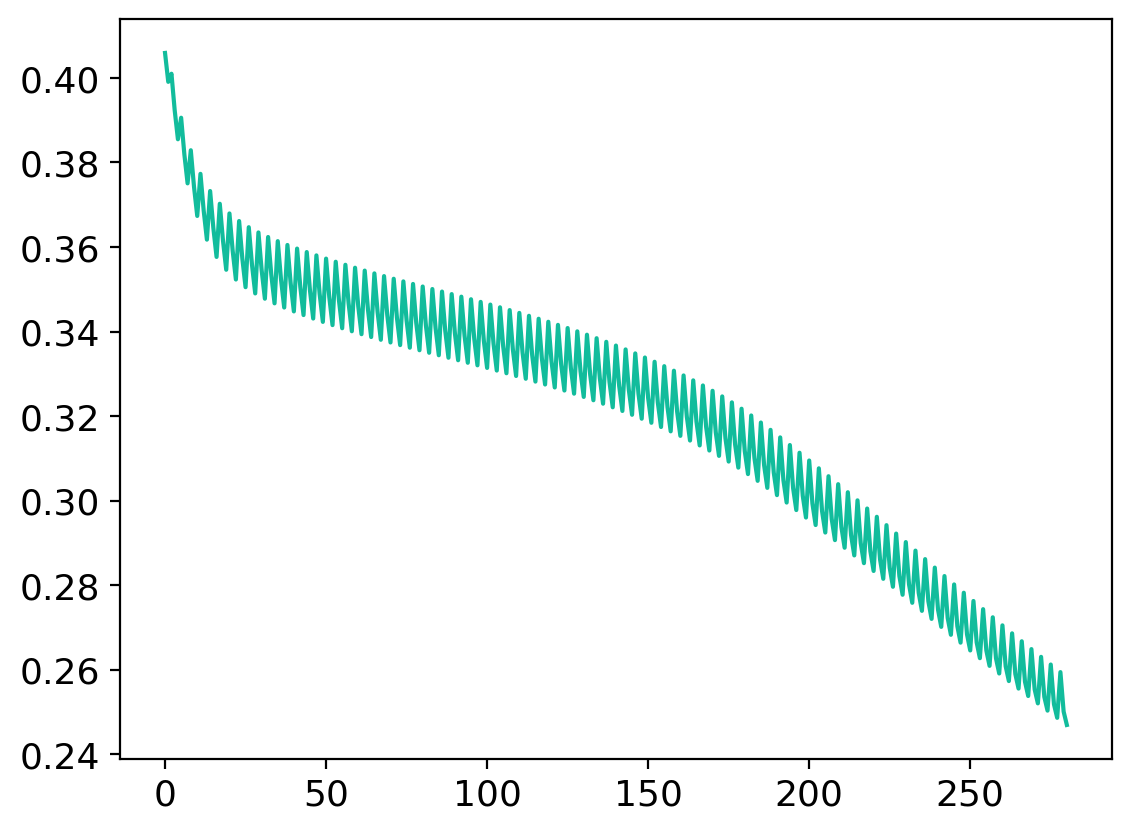

In [245]:
plt.plot(np.convolve(losses, kernel, mode='valid'), color=(18/255, 188/255, 156/255))

## Evaluate Models

In [217]:
loss_fn = nn.MSELoss()

In [4]:
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
Y_test = torch.tensor(Y_test_np, dtype=torch.float32, device=device)

NameError: name 'torch' is not defined

In [222]:
Y_test

tensor([[ 1.0065,  0.7734,  0.4620,  ...,  1.6111,  0.1155, -0.5246],
        [ 0.9582,  0.7088,  0.4148,  ...,  1.3526, -0.2422, -0.4391],
        [ 1.0870,  1.0047,  1.1338,  ...,  0.8680,  1.3709, -0.3100],
        ...,
        [ 1.4176,  1.1422,  0.7221,  ...,  1.6286,  0.7872, -0.4698],
        [ 1.4259,  1.2449,  1.0093,  ...,  0.9083,  1.5267, -0.4690],
        [ 1.4302,  1.2864,  1.3022,  ...,  1.0229,  1.9225, -0.1655]],
       device='cuda:0')

In [223]:
loss_fn(Y_hat, Y_test)

tensor(0.1892, device='cuda:0', grad_fn=<MseLossBackward0>)

# TF model

In [125]:
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 30
learning_rate  = 0.005
minibatch_size = 32
model_num      = 1
N_layers       = 2 # number of hidden layers

In [126]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(44,)))
for n in range(N_layers-1):
    model.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 

model.add(Dense(43,  activation='linear', name="output_layer")) # the output layer


model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [127]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 32)                1440      
                                                                 
 hidden_layer_2 (Dense)      (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 43)                1419      
                                                                 
Total params: 3,915
Trainable params: 3,915
Non-trainable params: 0
_________________________________________________________________


### Training Model

In [131]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train_np, Y_train_np, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/30


2023-07-25 06:45:43.283656: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-25 06:45:43.283741: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-25 06:45:43.283903: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-25 06:45:43.283967: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-25 06:45:43.284077: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-07-25 06:45:43.284116: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/srv/conda/envs/notebook/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/srv/conda/envs/notebook/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_404/489986324.py", line 4, in <module>
      history = model.fit(X_train_np, Y_train_np,
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_1272]